# Aritra MCS202304
## Assignment 5: Transfer Learning (Sentiment)

# Setting up the `environment`

## Downloading necessary libraries

In [129]:
!pip install --quiet transformers
!pip install --quiet torch
!pip install --quiet pandas
!pip install --quiet numpy
!pip install --quiet scikit-learn
!pip install --quiet kagglehub[pandas-datasets]
!pip install -q ipython-autotime

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 16.3 s (started: 2025-04-19 18:14:20 +00:00)


## Importing libaries

In [3]:
# Standard library and data handling
import pandas as pd
import numpy as np
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from IPython.display import display, HTML

# NLP and text processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
nltk.download('punkt')
nltk.download('punkt_tab')

# Deep learning and transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)

from torch.optim import AdamW

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Utility
import chardet
from tqdm import tqdm

# Kaggle
import kagglehub
from kagglehub import KaggleDatasetAdapter

time: 92.7 ms (started: 2025-04-19 15:54:20 +00:00)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Defining `Global vars`

In [122]:
EPOCHS = 10
LEARNING_RATE = 2e-5
EARLY_STOPPING_PATIENCE = 2
MIN_DELTA = 0.001
MAX_LEN = 128
BATCH_SIZE = 16

time: 513 µs (started: 2025-04-19 18:12:47 +00:00)


# Processing `datasets`

## Fetch dataset from Kaggle using `Kaggle API`

In [131]:
import kagglehub
dataset_path = kagglehub.dataset_download('abhi8923shriv/sentiment-analysis-dataset')

print('Data source import complete.')

Data source import complete.
time: 1.92 s (started: 2025-04-19 18:15:22 +00:00)


In [132]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv
/kaggle/input/sentiment-analysis-dataset/train.csv
/kaggle/input/sentiment-analysis-dataset/testdata.manual.2009.06.14.csv
/kaggle/input/sentiment-analysis-dataset/test.csv
time: 2.88 ms (started: 2025-04-19 18:15:29 +00:00)


## Utility functions

In [137]:
def get_file_encoding(file_path):
    """
    Detects the encoding of a file using chardet.
    """
    try:
        with open(file_path, 'rb') as f:
            raw_data = f.read(1024)
        return chardet.detect(raw_data)['encoding']
    except FileNotFoundError:
        raise
    except Exception as e:
        raise Exception(f"Encoding detection failed: {str(e)}")

time: 582 µs (started: 2025-04-19 18:16:19 +00:00)


In [138]:
def decode_and_load_csv(file_path):
    """
    Decodes a CSV file and loads it into a pandas DataFrame.
    """
    try:
        encoding = get_file_encoding(file_path)
        df = pd.read_csv(file_path, encoding=encoding)
        return df
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

time: 462 µs (started: 2025-04-19 18:16:20 +00:00)


## Load the dataset

In [139]:
train_df = decode_and_load_csv('/kaggle/input/sentiment-analysis-dataset/train.csv')
test_df = decode_and_load_csv('/kaggle/input/sentiment-analysis-dataset/test.csv')

time: 116 ms (started: 2025-04-19 18:16:22 +00:00)


# Exploratory Data Analysis and Preprocessing

## Plotting for train set

In [140]:
print(f"Training data has shape: {train_df.shape}")
print(f"Test data has shape: {test_df.shape}")

Training data has shape: (27481, 10)
Test data has shape: (4815, 9)
time: 837 µs (started: 2025-04-19 18:16:24 +00:00)


In [112]:
train_df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


time: 180 ms (started: 2025-04-19 18:09:39 +00:00)


sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64 



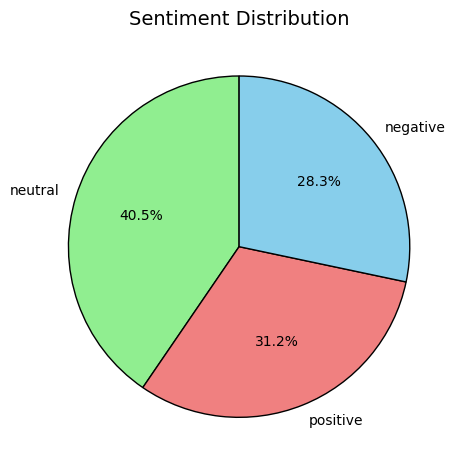

time: 76 ms (started: 2025-04-19 18:16:28 +00:00)


In [141]:
print(train_df['sentiment'].value_counts(), "\n")

train_df['sentiment'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightgreen', 'lightcoral', 'skyblue'],
    wedgeprops={'edgecolor': 'black', 'linewidth': 1}
)

plt.title('Sentiment Distribution', fontsize=14)
plt.ylabel('')
plt.tight_layout()
plt.show()

## Plotting for test set

In [84]:
test_df.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


time: 29.9 ms (started: 2025-04-19 17:17:10 +00:00)


sentiment
neutral     1430
positive    1103
negative    1001
Name: count, dtype: int64 



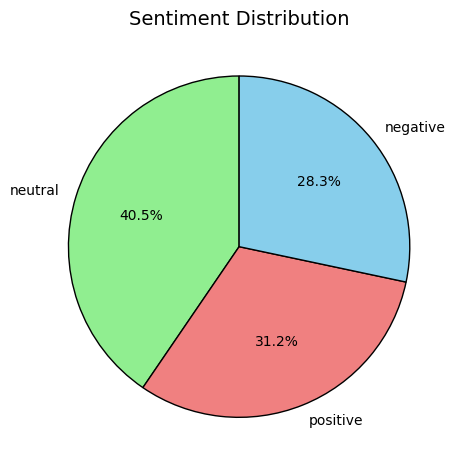

time: 77.8 ms (started: 2025-04-19 18:16:32 +00:00)


In [142]:
print(test_df['sentiment'].value_counts(), "\n")

test_df['sentiment'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightgreen', 'lightcoral', 'skyblue'],
    wedgeprops={'edgecolor': 'black', 'linewidth': 1}
)

plt.title('Sentiment Distribution', fontsize=14)
plt.ylabel('')
plt.tight_layout()
plt.show()

# Dropping missing columns

In [143]:
print("\nMissing values in training data:")
print(train_df[['text', 'sentiment']].isnull().sum())
print("\nMissing values in test data:")
print(test_df[['text', 'sentiment']].isnull().sum())

print("\nDropping those columns...")
train_df = train_df.dropna()
test_df = test_df.dropna()


Missing values in training data:
text         1
sentiment    0
dtype: int64

Missing values in test data:
text         1281
sentiment    1281
dtype: int64

Dropping those columns...
time: 24.2 ms (started: 2025-04-19 18:16:35 +00:00)


In [144]:
print("After dropping...")
print(f"Training data has shape: {train_df.shape}")
print(f"Test data has shape: {test_df.shape}")

After dropping...
Training data has shape: (27480, 10)
Test data has shape: (3534, 9)
time: 897 µs (started: 2025-04-19 18:16:39 +00:00)


## Map category to numbers

In [145]:
sentiment_mapping = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}
train_df['label'] = train_df['sentiment'].map(sentiment_mapping)
test_df['label'] = test_df['sentiment'].map(sentiment_mapping)

time: 5.98 ms (started: 2025-04-19 18:16:41 +00:00)


In [146]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 21984
Validation size: 5496
Test size: 3534
time: 11.4 ms (started: 2025-04-19 18:16:47 +00:00)


## Plotting for val set

In [115]:
val_df

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),label
1589,6c5505a37c,Enjoy! Family trumps everything,Enjoy! Family trumps everything,positive,night,70-100,Liechtenstein,38128,160.0,238,2
10414,126b1e6a22,--of them kinda turns me off of it all. And ...,kinda turns me off,negative,noon,60-70,Denmark,5792202,42430.0,137,0
6562,5bc4e623c4,Clive it`s my birthday pat me http://apps.fac...,Clive it`s my birthday pat me,neutral,noon,60-70,Israel,8655535,21640.0,400,1
2603,984d753104,congrats hey,congrats,positive,night,70-100,Bahamas,393244,10010.0,39,2
4004,8a79072ca2,is texting,is texting,neutral,night,31-45,Morocco,36910560,446300.0,83,1
...,...,...,...,...,...,...,...,...,...,...,...
12296,687aee2f7e,Just investigated whether I could change my u...,Just investigated whether I could change my us...,neutral,night,31-45,Djibouti,988000,23180.0,43,1
617,a82816a060,no one I know likes boiled peanuts t.,no one I know likes boiled peanuts t.,neutral,night,70-100,Canada,37742154,9093510.0,4,1
4505,f1f588a9bb,awww ) where`d you get that? hugh is so thin....,awww ) where`d you get that? hugh is so thin. ...,neutral,night,70-100,Canada,37742154,9093510.0,4,1
14492,4cca6419e7,Im craving some cinnamon toast crunch. Why is ...,so cold today!!,negative,night,31-45,Croatia,4105267,55960.0,73,0


time: 322 ms (started: 2025-04-19 18:10:38 +00:00)


sentiment
neutral     2236
positive    1688
negative    1572
Name: count, dtype: int64 



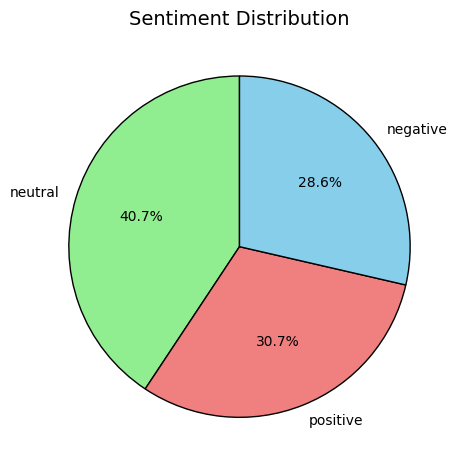

time: 78.4 ms (started: 2025-04-19 18:17:34 +00:00)


In [149]:
print(val_df['sentiment'].value_counts(), "\n")

val_df['sentiment'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightgreen', 'lightcoral', 'skyblue'],
    wedgeprops={'edgecolor': 'black', 'linewidth': 1}
)

plt.title('Sentiment Distribution', fontsize=14)
plt.ylabel('')
plt.tight_layout()
plt.show()

## Plotting `word clouds`

In [45]:
def plot_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         max_words=100).generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

time: 638 µs (started: 2025-04-19 16:12:11 +00:00)


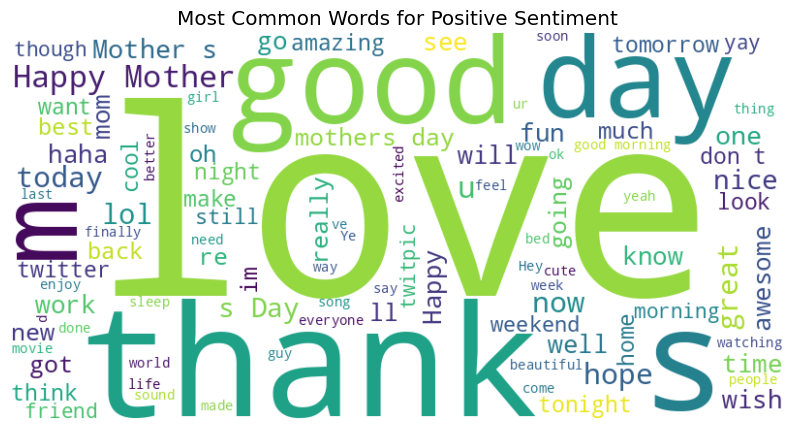

time: 1.25 s (started: 2025-04-19 17:22:05 +00:00)


In [95]:
text = ' '.join(train_df[train_df['sentiment'] == 'positive']['text'].astype(str))
plot_word_cloud(text, f'Most Common Words for Positive Sentiment')

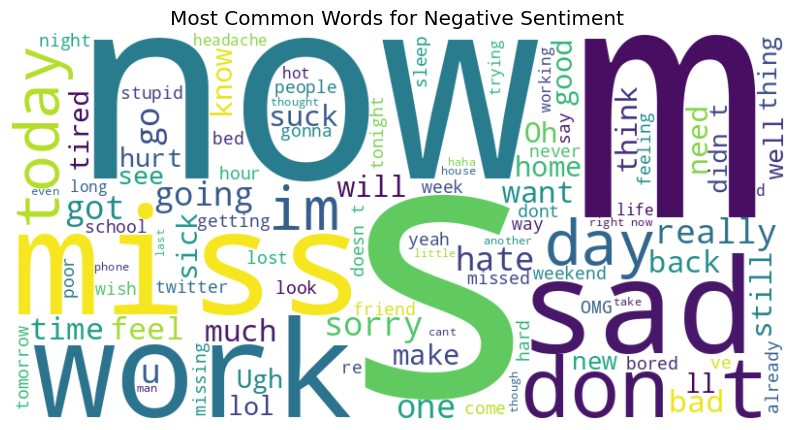

time: 759 ms (started: 2025-04-19 17:22:12 +00:00)


In [96]:
text = ' '.join(train_df[train_df['sentiment'] == 'negative']['text'].astype(str))
plot_word_cloud(text, f'Most Common Words for Negative Sentiment')

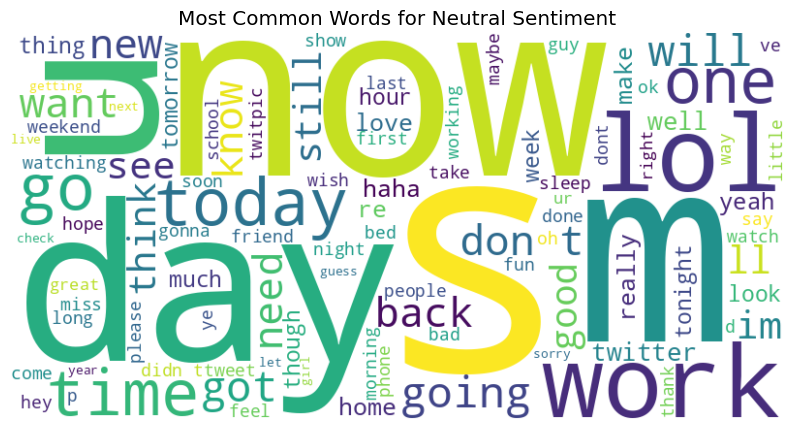

time: 873 ms (started: 2025-04-19 17:22:25 +00:00)


In [97]:
text = ' '.join(train_df[train_df['sentiment'] == 'neutral']['text'].astype(str))
plot_word_cloud(text, f'Most Common Words for Neutral Sentiment')

# Training the model

## Define Dataset class

In [150]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

time: 1.07 ms (started: 2025-04-19 18:18:00 +00:00)


## Load the `model` and the `tokenizer` for `bert-base-uncased`

In [151]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3, # mapping to 3 classes
    output_attentions=False,
    output_hidden_states=False
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


time: 471 ms (started: 2025-04-19 18:18:05 +00:00)


In [152]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Using device: {device}")

Using device: cuda
time: 162 ms (started: 2025-04-19 18:18:13 +00:00)


In [153]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Setting up `dataloaders`

In [155]:
dataset_config = {
    'train': {'df': train_df, 'shuffle': True},
    'val': {'df': val_df, 'shuffle': False},
    'test': {'df': test_df, 'shuffle': False}
}

datasets = {}
data_loaders = {}

for name, config in dataset_config.items():
    datasets[name] = SentimentAnalysisDataset(
        config['df'].text.values,
        config['df'].label.values,
        tokenizer,
        MAX_LEN
    )

    data_loaders[name] = DataLoader(
        datasets[name],
        batch_size=BATCH_SIZE,
        shuffle=config['shuffle']
    )

train_loader = data_loaders['train']
val_loader = data_loaders['val']
test_loader = data_loaders['test']

time: 1.53 ms (started: 2025-04-19 18:18:30 +00:00)


This following code creates a **linear learning rate scheduler with warmup** (commonly used in training Transformer models like BERT).

- **If `num_warmup_steps > 0`:**
  - **Warmup Phase:** Learning rate linearly increases from `0` to `max_lr` over `num_warmup_steps`.
  - **Decay Phase:** After warmup, LR linearly decreases to `0` over the remaining steps.

- **If `num_warmup_steps=0`:**
  - No warmup phase; LR immediately starts decaying from `max_lr` to `0` linearly across all steps.

---

### Why Use This?
- **Warmup** (when enabled) helps stabilize training early on (critical for Transformers).
- **Linear decay** provides a smooth reduction in LR, often leading to better convergence.

---

### Example Curve (`num_warmup_steps=10`, `num_training_steps=100`):
```
LR
|     /\
|    /  \
|   /    \
|__/      \__ Steps
 10  100
```

In [162]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
loss_fn = torch.nn.CrossEntropyLoss().to(device)

warmup_steps = 0
training_steps = total_steps

scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=training_steps
)

time: 1.96 ms (started: 2025-04-19 18:51:59 +00:00)


## Train the model

In [166]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    """Trains the model for one epoch."""
    model.train()
    total_loss = 0.0
    correct_predictions = 0

    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(preds == labels).item()
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / len(data_loader.dataset)
    return accuracy, avg_loss

def eval_model(model, data_loader, loss_fn, device):
    """Evaluates the model on the validation set."""
    model.eval()
    total_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            preds = torch.argmax(logits, dim=1)
            correct_predictions += torch.sum(preds == labels).item()
            total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / len(data_loader.dataset)
    return accuracy, avg_loss

time: 1.37 ms (started: 2025-04-19 19:02:02 +00:00)


### Early stopping
The pre-trained models seems to be prone to overfitting while fine-tuning. So, I've used `early stopping` to detect when to stop.

In [167]:
def run_training(model, train_loader, val_loader, loss_fn, optimizer, scheduler, device,
                epochs, early_stopping_patience, min_delta):
    """Runs the training loop with early stopping."""
    best_accuracy = 0
    patience_counter = 0
    best_model_path = 'best_model_state.bin'

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
            model, train_loader, loss_fn, optimizer, device, scheduler
        )
        print(f'Train loss {train_loss:.4f} accuracy {train_acc:.4f}')

        val_acc, val_loss = eval_model(
            model, val_loader, loss_fn, device
        )
        print(f'Validation loss {val_loss:.4f} accuracy {val_acc:.4f}')

        if val_acc > best_accuracy + min_delta:
            best_accuracy = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"Validation accuracy improved to {val_acc:.4f}, saving model...")
        else:
            patience_counter += 1
            print(f"No improvement in validation accuracy ({patience_counter}/{early_stopping_patience})")
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered!")
                break

        print()

    model.load_state_dict(torch.load(best_model_path))
    print(f"Training complete! Best validation accuracy: {best_accuracy:.4f}")
    return model

time: 916 µs (started: 2025-04-19 19:02:04 +00:00)


In [168]:
trained_model = run_training(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=EPOCHS,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    min_delta=MIN_DELTA
)

Epoch 1/10
----------


Training: 100%|██████████| 1374/1374 [07:39<00:00,  2.99it/s]


Train loss 0.4027 accuracy 0.8452


Evaluation: 100%|██████████| 344/344 [00:38<00:00,  8.87it/s]


Validation loss 0.5238 accuracy 0.7948
Validation accuracy improved to 0.7948, saving model...

Epoch 2/10
----------


Training: 100%|██████████| 1374/1374 [07:40<00:00,  2.99it/s]


Train loss 0.2693 accuracy 0.9083


Evaluation: 100%|██████████| 344/344 [00:39<00:00,  8.61it/s]


Validation loss 0.7487 accuracy 0.7868
No improvement in validation accuracy (1/2)

Epoch 3/10
----------


Training: 100%|██████████| 1374/1374 [07:39<00:00,  2.99it/s]


Train loss 0.1768 accuracy 0.9464


Evaluation: 100%|██████████| 344/344 [00:38<00:00,  8.84it/s]


Validation loss 0.7932 accuracy 0.7917
No improvement in validation accuracy (2/2)
Early stopping triggered!
Training complete! Best validation accuracy: 0.7948
time: 25min 2s (started: 2025-04-19 19:02:05 +00:00)


# Testing the model

In [169]:
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

def get_predictions(model, data_loader, device):
    """Generate predictions and collect true labels from a data loader."""
    model.eval().to(device)
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device)
            }
            labels = batch['label'].to(device)

            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    return torch.cat(all_preds).numpy(), torch.cat(all_labels).numpy()

time: 329 ms (started: 2025-04-19 19:31:42 +00:00)


## Printing the classification report

In [170]:
y_pred, y_test = get_predictions(model, test_loader, device)

print("\nClassification Report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=['negative', 'neutral', 'positive']
))


Classification Report:
              precision    recall  f1-score   support

    negative       0.77      0.82      0.80      1001
     neutral       0.77      0.74      0.76      1430
    positive       0.84      0.83      0.84      1103

    accuracy                           0.79      3534
   macro avg       0.79      0.80      0.80      3534
weighted avg       0.79      0.79      0.79      3534

time: 25.2 s (started: 2025-04-19 19:31:46 +00:00)


## View the model's performance on a test sample

In [173]:
def generate_sentiment_report(model, tokenizer, test_df, device, max_len=128):
    """Generates a sentiment analysis report comparing predictions with actual labels."""
    LABEL_MAPPING = {0: 'negative', 1: 'neutral', 2: 'positive'}
    model = model.to(device).eval()

    report_df = test_df.copy()
    predictions = []

    texts = test_df['text'].astype(str).tolist()
    encodings = tokenizer(
        texts,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt',
        return_attention_mask=True,
        add_special_tokens=True
    )

    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()

    report_df['predicted_label'] = batch_preds
    report_df['predicted_sentiment'] = report_df['predicted_label'].map(LABEL_MAPPING)
    report_df['match'] = report_df['predicted_label'] == report_df['label']
    report_df['match_symbol'] = report_df['match'].map({True: '✓', False: '✗'})

    accuracy = report_df['match'].mean()

    display_cols = ['text', 'sentiment', 'predicted_sentiment', 'match_symbol']
    styled_report = (
        report_df[display_cols]
        .rename(columns={'match_symbol': 'match'})
        .style
        .set_caption(f"Sentiment Analysis Report (Accuracy: {accuracy:.2%})")
        .set_properties(**{'text-align': 'left'})
        .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])
    )

    display(styled_report)
    print(f"\nFinal Accuracy on sampled Test Set: {accuracy:.2%}")

    return report_df, accuracy

time: 4.34 ms (started: 2025-04-19 19:34:09 +00:00)


In [175]:
report_df, accuracy = generate_sentiment_report(
    model=model,
    tokenizer=tokenizer,
    test_df=test_df.sample(100, random_state=42).copy(),
    device=device
)

,text,sentiment,predicted_sentiment,match
325,Thank you so much phaoloo !!!!,positive,positive,✓
2226,Midnight ice-cream weather! So **** bored,negative,negative,✓
2480,Ohh i forgot to tell you last night that when i was a alton towers i touched a shark it was amazing !!!! it was nt a massive one tho,positive,positive,✓
1862,i am the only arabic girl who`s online every one is a sleep ..,neutral,neutral,✓
299,starting the video editing of the first spanking movie we did with Mina ... it will be added to the next update,neutral,neutral,✓
1637,I have it. Hehehehe u want the torrent?,neutral,neutral,✓
2374,I wanna do something tonight after work.... But I dunno what...,neutral,neutral,✓
3355,in school w. linda doing nothing ;i miss you,negative,negative,✓
139,love your books,positive,positive,✓
1456,I wanna crawl under my desk and take a nap nvrmind its dirty =/,negative,negative,✓



Final Accuracy on Test Set: 88.00%
time: 825 ms (started: 2025-04-19 19:34:17 +00:00)
